In [1]:
import math
from pickle import FALSE

import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
from numpy.ma.core import left_shift

In [2]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

pose = mp_pose.Pose(
    static_image_mode=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity = 1
)

In [6]:
def detectPose(image, pose, display=True):
    '''
    Perform pose detection on an image.
    Args:
        image: Input image with a prominent person for pose detection.
        pose: Mediapipe pose function for detection.
        display: If True, display the images and landmarks.
    Returns:
        output_image: Image with detected pose landmarks drawn.
        landmarks: List of detected landmarks in original scale.
    '''
    # Create a copy of the input image.
    output_image = image.copy()

    # Convert BGR to RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform Pose Detection.
    results = pose.process(imageRGB)

    # Retrieve the image dimensions.
    height, width, _ = image.shape

    # Initialize list for landmarks.
    landmarks = []

    # If landmarks are detected.
    if results.pose_landmarks:
        # Draw Pose landmarks on the image.
        mp_drawing.draw_landmarks(
            image=output_image,
            landmark_list=results.pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS
        )

        # Save the landmarks.
        for landmark in results.pose_landmarks.landmark:
            landmarks.append((int(landmark.x * width), int(landmark.y * height), landmark.z * width))

    # Display results if requested.
    if display:
        plt.figure(figsize=[22, 22])
        plt.subplot(121);
        plt.imshow(image[:, :, ::-1]);
        plt.title("Original Image");
        plt.axis('off');
        plt.subplot(122);
        plt.imshow(output_image[:, :, ::-1]);
        plt.title("Output Image");
        plt.axis('off');
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    else:
        return output_image, landmarks

In [35]:

# Initialize Pose function for video.
pose_video = mp_pose.Pose(
    static_image_mode=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=1
)

# Open the webcam (change index to 1 if another camera is used).
video = cv2.VideoCapture(0)

# Create named window for resizing.
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)

# Set video resolution.
video.set(3, 1280)  # Width
video.set(4, 960)  # Height

# Initialize time for FPS calculation.
time1 = 0

# Video capture loop.
while video.isOpened():
    # Read a frame.
    ok, frame = video.read()

    # If frame is not read properly, break the loop.
    if not ok:
        print("Error: Unable to read frame.")
        break

    # Flip the frame horizontally for natural view.
    frame = cv2.flip(frame, 1)

    # Resize the frame.
    frame_height, frame_width, _ = frame.shape
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))

    # Perform pose detection.
    try:
        # Convert the frame to RGB for processing.
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Perform pose detection.
        results = pose_video.process(rgb_frame)

        # If landmarks are detected, process them.
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # Print and optionally process landmarks.
            for i, landmark in enumerate(landmarks):
                print(
                    f"Landmark {i}: x={landmark.x:.3f}, y={landmark.y:.3f}, z={landmark.z:.3f}, visibility={landmark.visibility:.2f}"
                )

                # Optionally, convert normalized coordinates to pixels.
                pixel_x = int(landmark.x * frame_width)
                pixel_y = int(landmark.y * frame_height)
                print(f"Landmark {i} in pixels: x={pixel_x}, y={pixel_y}")

            # Draw pose landmarks on the frame.
            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
            )

    except Exception as e:
        print("Error during pose detection:", e)
        continue

    # Calculate and display FPS.
    time2 = time()
    if (time2 - time1) > 0:
        fps = 1.0 / (time2 - time1)
        cv2.putText(frame, f'FPS: {int(fps)}', (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    time1 = time2

    # Display the frame.
    cv2.imshow('Pose Detection', frame)

    # Break on 'ESC' key press.
    if cv2.waitKey(1) & 0xFF == 27:
        break

# Release the video capture object and close windows.
video.release()
cv2.destroyAllWindows()


Landmark 0: x=0.381, y=0.744, z=-1.221, visibility=1.00
Landmark 0 in pixels: x=488, y=535
Landmark 1: x=0.407, y=0.668, z=-1.171, visibility=1.00
Landmark 1 in pixels: x=520, y=481
Landmark 2: x=0.419, y=0.669, z=-1.171, visibility=1.00
Landmark 2 in pixels: x=536, y=481
Landmark 3: x=0.433, y=0.671, z=-1.172, visibility=1.00
Landmark 3 in pixels: x=553, y=482
Landmark 4: x=0.374, y=0.676, z=-1.187, visibility=1.00
Landmark 4 in pixels: x=478, y=486
Landmark 5: x=0.358, y=0.676, z=-1.188, visibility=1.00
Landmark 5 in pixels: x=457, y=486
Landmark 6: x=0.327, y=0.656, z=-1.188, visibility=1.00
Landmark 6 in pixels: x=419, y=472
Landmark 7: x=0.444, y=0.694, z=-0.833, visibility=0.99
Landmark 7 in pixels: x=568, y=499
Landmark 8: x=0.299, y=0.671, z=-0.899, visibility=1.00
Landmark 8 in pixels: x=383, y=483
Landmark 9: x=0.407, y=0.810, z=-1.085, visibility=0.99
Landmark 9 in pixels: x=520, y=582
Landmark 10: x=0.356, y=0.804, z=-1.105, visibility=1.00
Landmark 10 in pixels: x=456, y=5

KeyboardInterrupt: 

In [36]:
for lndmrk in mp_pose.PoseLandmark:
    print(lndmrk)

PoseLandmark.NOSE
PoseLandmark.LEFT_EYE_INNER
PoseLandmark.LEFT_EYE
PoseLandmark.LEFT_EYE_OUTER
PoseLandmark.RIGHT_EYE_INNER
PoseLandmark.RIGHT_EYE
PoseLandmark.RIGHT_EYE_OUTER
PoseLandmark.LEFT_EAR
PoseLandmark.RIGHT_EAR
PoseLandmark.MOUTH_LEFT
PoseLandmark.MOUTH_RIGHT
PoseLandmark.LEFT_SHOULDER
PoseLandmark.RIGHT_SHOULDER
PoseLandmark.LEFT_ELBOW
PoseLandmark.RIGHT_ELBOW
PoseLandmark.LEFT_WRIST
PoseLandmark.RIGHT_WRIST
PoseLandmark.LEFT_PINKY
PoseLandmark.RIGHT_PINKY
PoseLandmark.LEFT_INDEX
PoseLandmark.RIGHT_INDEX
PoseLandmark.LEFT_THUMB
PoseLandmark.RIGHT_THUMB
PoseLandmark.LEFT_HIP
PoseLandmark.RIGHT_HIP
PoseLandmark.LEFT_KNEE
PoseLandmark.RIGHT_KNEE
PoseLandmark.LEFT_ANKLE
PoseLandmark.RIGHT_ANKLE
PoseLandmark.LEFT_HEEL
PoseLandmark.RIGHT_HEEL
PoseLandmark.LEFT_FOOT_INDEX
PoseLandmark.RIGHT_FOOT_INDEX


In [64]:
landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value]


x: 0.0314181224
y: 0.769613504
z: -0.635931909
visibility: 0.997855544

Landmark 0: x=501.06, y=187.00, z=-1867.88
Landmark 1: x=542.94, y=119.55, z=-1886.25
Landmark 2: x=569.89, y=116.74, z=-1885.83
Landmark 3: x=591.37, y=114.92, z=-1886.34
Landmark 4: x=458.44, y=119.14, z=-1879.31
Landmark 5: x=426.34, y=116.04, z=-1879.66
Landmark 6: x=398.21, y=113.54, z=-1879.88
Landmark 7: x=622.63, y=116.30, z=-1607.24
Landmark 8: x=362.55, y=106.57, z=-1563.05
Landmark 9: x=546.21, y=238.90, z=-1729.05
Landmark 10: x=457.34, y=246.61, z=-1716.71
Landmark 11: x=751.23, y=377.42, z=-1214.45
Landmark 12: x=253.58, y=265.34, z=-1145.09
Landmark 13: x=837.04, y=710.07, z=-1046.60
Landmark 14: x=61.11, y=586.91, z=-984.78
Landmark 15: x=871.22, y=1021.58, z=-1075.33
Landmark 16: x=-54.54, y=905.29, z=-1112.25
Landmark 17: x=900.01, y=1099.50, z=-1111.57
Landmark 18: x=-106.64, y=978.29, z=-1145.70
Landmark 19: x=874.85, y=1110.02, z=-1182.00
Landmark 20: x=-71.87, y=985.05, z=-1239.57
Landmark 21: x=847.21, y=1082.36, z=-1106.40
Landmark 22: x=-36.73, y=963.10, z=-115

KeyboardInterrupt: 

In [66]:
#lets see this one
def calculate_angle(a, b, c):
    a = np.array(a)  # First point
    b = np.array(b)  # Midpoint
    c = np.array(c)  # End point
    
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle 

cap = cv2.VideoCapture(0)
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        try:
            landmarks = results.pose_landmarks.landmark

            # Extract relevant points
            joint_sets = {
                "Left Arm": [mp_pose.PoseLandmark.LEFT_SHOULDER, 
                             mp_pose.PoseLandmark.LEFT_ELBOW, 
                             mp_pose.PoseLandmark.LEFT_WRIST],
                
                "Right Arm": [mp_pose.PoseLandmark.RIGHT_SHOULDER, 
                              mp_pose.PoseLandmark.RIGHT_ELBOW, 
                              mp_pose.PoseLandmark.RIGHT_WRIST],

                "Left Leg": [mp_pose.PoseLandmark.LEFT_HIP, 
                             mp_pose.PoseLandmark.LEFT_KNEE, 
                             mp_pose.PoseLandmark.LEFT_ANKLE],

                "Right Leg": [mp_pose.PoseLandmark.RIGHT_HIP, 
                              mp_pose.PoseLandmark.RIGHT_KNEE, 
                              mp_pose.PoseLandmark.RIGHT_ANKLE],

                "Torso": [mp_pose.PoseLandmark.LEFT_SHOULDER, 
                          mp_pose.PoseLandmark.LEFT_HIP, 
                          mp_pose.PoseLandmark.LEFT_KNEE]
            }

            for joint_name, points in joint_sets.items():
                p1 = [landmarks[points[0].value].x, landmarks[points[0].value].y]
                p2 = [landmarks[points[1].value].x, landmarks[points[1].value].y]
                p3 = [landmarks[points[2].value].x, landmarks[points[2].value].y]
                
                angle = calculate_angle(p1, p2, p3)
                
                # Print angle values to console
                print(f"{joint_name} angle: {angle:.2f}")

                # Visualize angle on screen
                cv2.putText(image, f"{joint_name}: {int(angle)}", 
                            tuple(np.multiply(p2, [640, 480]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

        except:
            pass
        
        # Render pose landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

        cv2.imshow('Mediapipe Pose Estimation', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

Left Arm angle: 168.51
Right Arm angle: 164.22
Left Leg angle: 178.71
Right Leg angle: 179.14
Torso angle: 179.16
Left Arm angle: 107.39
Right Arm angle: 160.92
Left Leg angle: 178.69
Right Leg angle: 179.35
Torso angle: 177.33
Left Arm angle: 3.41
Right Arm angle: 44.93
Left Leg angle: 177.72
Right Leg angle: 167.94
Torso angle: 173.55
Left Arm angle: 35.88
Right Arm angle: 1.29
Left Leg angle: 177.41
Right Leg angle: 168.22
Torso angle: 178.10
Left Arm angle: 14.74
Right Arm angle: 41.67
Left Leg angle: 176.95
Right Leg angle: 148.55
Torso angle: 173.48
Left Arm angle: 40.57
Right Arm angle: 25.94
Left Leg angle: 173.38
Right Leg angle: 149.21
Torso angle: 171.35
Left Arm angle: 35.39
Right Arm angle: 19.39
Left Leg angle: 177.89
Right Leg angle: 164.58
Torso angle: 174.60
Left Arm angle: 29.24
Right Arm angle: 20.00
Left Leg angle: 177.11
Right Leg angle: 151.93
Torso angle: 173.80
Left Arm angle: 14.06
Right Arm angle: 18.20
Left Leg angle: 175.14
Right Leg angle: 156.91
Torso angl

KeyboardInterrupt: 

TypeError: cannot unpack non-iterable NormalizedLandmark object

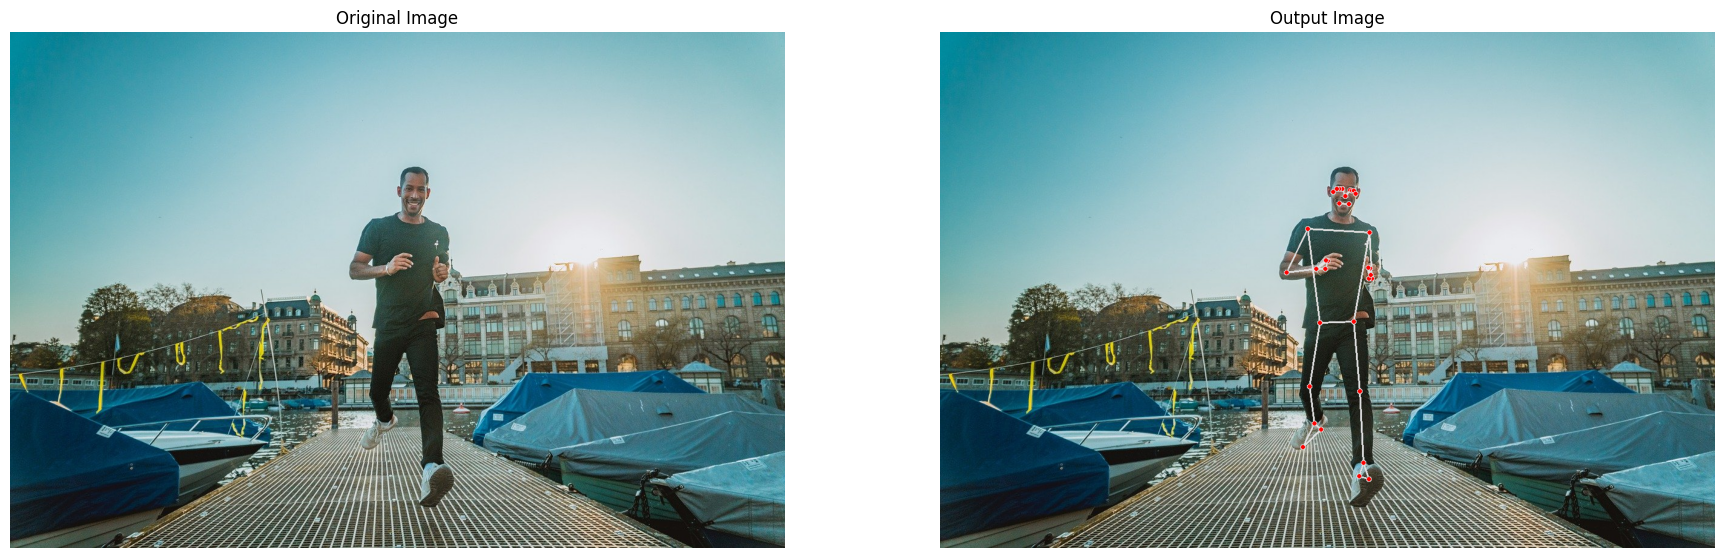

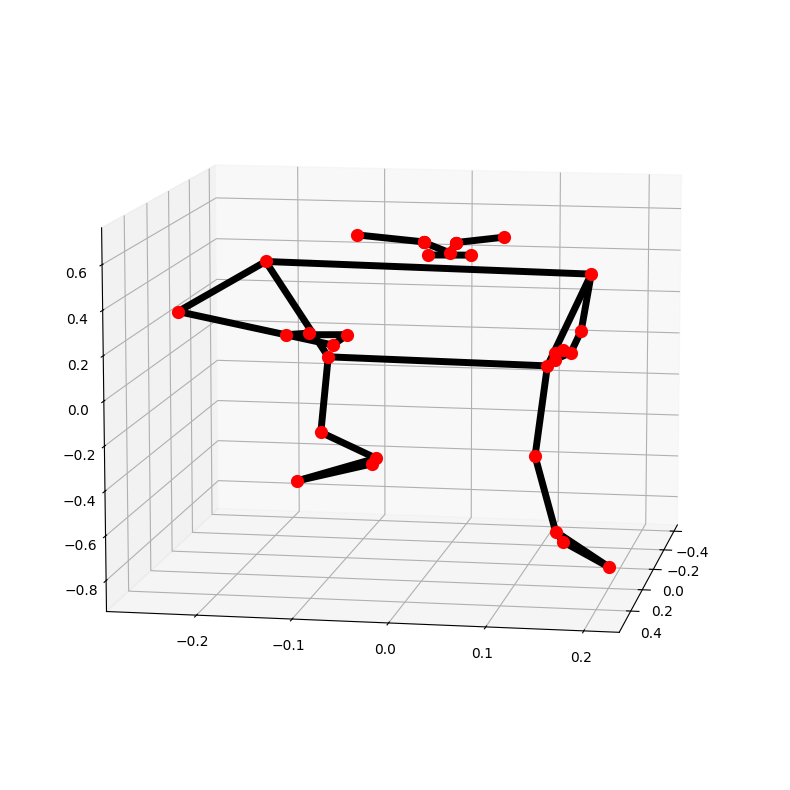

In [9]:
image = cv2.imread('media/sample1.jpg')
detectPose(image, pose, display=1)

In [7]:
#################### Pose Identify Using Values
def calculateAngle(landmark1, landmark2, landmark3):
    '''
    This function calculates angle between three different landmarks.
    Args:
        landmark1: The first landmark containing the x,y and z coordinates.
        landmark2: The second landmark containing the x,y and z coordinates.
        landmark3: The third landmark containing the x,y and z coordinates.
    Returns:
        angle: The calculated angle between the three landmarks.

    '''

    # Get the required landmarks coordinates.
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3

    # Calculate the angle between the three points
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    
    # Check if the angle is less than zero.
    if angle < 0:

        # Add 360 to the found angle.
        angle += 360
    
    # Return the calculated angle.
    return angle

In [8]:
# Calculate the angle between the three landmarks.
angle = calculateAngle((558, 326, 0), (642, 333, 0), (718, 321, 0))

# Display the calculated angle.
print(f'The calculated angle is {angle}')

The calculated angle is 166.26373169437744


In [10]:
def classifyPose(landmarks, output_image, display=False):
    '''
    This function classifies yoga poses depending upon the angles of various body joints.
    Args:
        landmarks: A list of detected landmarks of the person whose pose needs to be classified.
        output_image: A image of the person with the detected pose landmarks drawn.
        display: A boolean value that is if set to true the function displays the resultant image with the pose label 
        written on it and returns nothing.
    Returns:
        output_image: The image with the detected pose landmarks drawn and pose label written.
        label: The classified pose label of the person in the output_image.

    '''
    
    # Initialize the label of the pose. It is not known at this stage.
    label = 'Unknown Pose'

    # Specify the color (Red) with which the label will be written on the image.
    color = (0, 0, 255)
    
    # Calculate the required angles.
    #----------------------------------------------------------------------------------------------------------------
    
    # Get the angle between the left shoulder, elbow and wrist points. 
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    # Get the angle between the right shoulder, elbow and wrist points. 
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    
    # Get the angle between the left elbow, shoulder and hip points. 
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    # Get the angle between the right hip, shoulder and elbow points. 
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    # Get the angle between the left hip, knee and ankle points. 
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    # Get the angle between the right hip, knee and ankle points 
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if it is the warrior II pose or the T pose.
    # As for both of them, both arms should be straight and shoulders should be at the specific angle.
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if the both arms are straight.
    if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:

        # Check if shoulders are at the required angle.
        if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle < 110:

    # Check if it is the warrior II pose.
    #----------------------------------------------------------------------------------------------------------------

            # Check if one leg is straight.
            if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:

                # Check if the other leg is bended at the required angle.
                if left_knee_angle > 90 and left_knee_angle < 120 or right_knee_angle > 90 and right_knee_angle < 120:

                    # Specify the label of the pose that is Warrior II pose.
                    label = 'Warrior II Pose' 
                        
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if it is the T pose.
    #----------------------------------------------------------------------------------------------------------------
    
            # Check if both legs are straight
            if left_knee_angle > 160 and left_knee_angle < 195 and right_knee_angle > 160 and right_knee_angle < 195:

                # Specify the label of the pose that is tree pose.
                label = 'T Pose'

    #----------------------------------------------------------------------------------------------------------------
    
    # Check if it is the tree pose.
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if one leg is straight
    if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:

        # Check if the other leg is bended at the required angle.
        if left_knee_angle > 315 and left_knee_angle < 335 or right_knee_angle > 25 and right_knee_angle < 45:

            # Specify the label of the pose that is tree pose.
            label = 'Tree Pose'
                
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if the pose is classified successfully
    if label != 'Unknown Pose':
        
        # Update the color (to green) with which the label will be written on the image.
        color = (0, 255, 0)  
    
    # Write the label on the output image. 
    cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    
    # Check if the resultant image is specified to be displayed.
    if display:
    
        # Display the resultant image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    else:
        
        # Return the output image and the classified label.
        return output_image, label